In [1]:
import warnings
import os
import json  # If loading presaved indexes using freeze_model
import shap

import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import RepeatedKFold
from dotenv import load_dotenv

from models.linear_regressions import Linear_reg
from scripts.model_actions import freeze_model

load_dotenv()
sns.color_palette('colorblind')
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

pc_dpi = int(os.getenv('DPI'))

if pc_dpi is None:
    pc_dpi = 100


warnings.filterwarnings("ignore")

shap.initjs()


# <u>Tentative de modelisation et prédiction de la variable : Intensité d'utilisation energetique</u>

## <u>1 : Modelisations en prenant en compte la note Energy Star (E*)</u>
### <u>1.1 : Regressions lineaires</u>

## <u>2 : Etude de l'importance de la note Energy Star</u>
### <u>2.1 : Modelisation sans utiliser de variables E* (E* Score ou E* certified)</u>
### <u>2.2 : Utilisation de la certification plutot que le score</u>


## <u>1 : Modelisations prenant en compte toutes les variables retenues lors de l'étude</u>
### <u>1.1 : Regressions lineaires</u>

#### 1.1.a : Cross validation = Leave One Out
- On utilise dans un premier temps toutes les variables retenues lors de l'analyse exploratoire (breakpoint = export 1)
- Un split satisfaisant a deja été trouvé et fixé, ces données viendront sur-ecrire le split proposé par le modele
- On effectue 4 regressions (OLS, Ridge, Lasso et Elastic Net) avec les parametres par defaut de la classe pour la validation croisee : Leave One Out

In [2]:
general_file = "./data/seattle_predict_ghg_eui.csv"  # Used as backup


In [3]:
df_eui = pd.read_csv(general_file)
df_eui.set_index("OSEBuildingID", inplace=True)


In [4]:
## Opening split

with open("./data/split_eui.json") as json_file:
    splits = json.load(json_file)


In [5]:
ids_train = splits["train"]
ids_test = splits["test"]


In [6]:
df_eui.head()


,scaled_Electricity(kWh),scaled_GHGEmissionsIntensity(kgCO2e/ft2),scaled_PropertyArea(SquareMetre)Total,scaled_SourceEUI(kWh/m2),scaled_NaturalGas(kWh),YearBuilt,NumberofBuildings,NumberofFloors,ENERGYSTARScore,Building_proportion,...,ohe_ptype_Mixed Use Property,ohe_ptype_Office,ohe_ptype_Other,ohe_ptype_Refrigerated Warehouse,ohe_ptype_Residence Hall,ohe_ptype_Small & Medium medical facility,ohe_ptype_Small & Mid-Sized Office,ohe_ptype_Supermarket & Grocery store,ohe_ptype_Warehouse,ohe_ptype_Worship Facility
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,
1,0.963847,1.770173,0.389139,1.012887,0.500705,1927,1,12,60.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.615322,1.799564,0.659821,0.913481,4.178122,1996,1,11,61.0,0.855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.380423,3.572830,-0.095878,1.536320,1.009034,1926,1,10,56.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.401384,1.074583,0.292078,0.455283,2.089235,1926,1,11,27.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,-0.326328,3.945117,-0.029889,0.564008,2.706276,1928,1,9,48.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_eui.columns


Index(['scaled_Electricity(kWh)', 'scaled_GHGEmissionsIntensity(kgCO2e/ft2)',
       'scaled_PropertyArea(SquareMetre)Total', 'scaled_SourceEUI(kWh/m2)',
       'scaled_NaturalGas(kWh)', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'ENERGYSTARScore', 'Building_proportion',
       'Parking_proportion', 'target_SourceEUI(kWh/m2)',
       'target_GHGEmissionsIntensity(kgCO2e/ft2)', 'ohe_nbhood_BALLARD',
       'ohe_nbhood_CENTRAL', 'ohe_nbhood_DELRIDGE', 'ohe_nbhood_DOWNTOWN',
       'ohe_nbhood_EAST', 'ohe_nbhood_GREATER DUWAMISH',
       'ohe_nbhood_LAKE UNION', 'ohe_nbhood_MAGNOLIA / QUEEN ANNE',
       'ohe_nbhood_NORTH', 'ohe_nbhood_NORTHEAST', 'ohe_nbhood_NORTHWEST',
       'ohe_nbhood_SOUTHEAST', 'ohe_nbhood_SOUTHWEST', 'ohe_ptype_Hospital',
       'ohe_ptype_Hotel', 'ohe_ptype_K-12 School', 'ohe_ptype_Large Office',
       'ohe_ptype_Mixed Use Property', 'ohe_ptype_Office', 'ohe_ptype_Other',
       'ohe_ptype_Refrigerated Warehouse', 'ohe_ptype_Residence Hall',
    

In [8]:
# Target : target_SourceEUI(kWh/m2) :

droplist = [
    "target_GHGEmissionsIntensity(kgCO2e/ft2)",  # Scaled target
    "scaled_SourceEUI(kWh/m2)",  # not to scale
    ]

df_model = df_eui.drop(columns=droplist)


In [9]:
eui_target = "target_SourceEUI(kWh/m2)"
eui_regression = Linear_reg(dataframe=df_model, target=eui_target)


In [10]:
# Forcing split : 

df_train_override = df_model[df_model.index.isin(ids_train)]
df_test_override = df_model[df_model.index.isin(ids_test)]


In [11]:
eui_regression.force_split(
    df_test_ovr=df_test_override,
    df_train_ovr=df_train_override
)


#### Execution : 
Parametres similaires à l'emission de GES, on ajustera au besoin: 
- Ridge = 0.1, 30, step 0.04
- Elastic Net = Alpha = Alpha_ridge = 0.1, 30, step 0.04, default L1 ratio
- Lasso Alpha = 0.01, 10, 0.02

In [12]:
alphas_ridge = np.arange(0.1, 30, 0.04)
alphas_elnet = np.arange(0.1, 30, 0.04)
alphas_lasso = np.arange(0.01, 6, 0.01)

eui_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_lasso=alphas_lasso,
    alphas_ridge=alphas_ridge
)


In [13]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {eui_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {eui_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {eui_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.9600000000000001
Elastic Net best Alpha : 0.42000000000000004
Time used during fit = 8.045408500000008
Time used during predict = 0.0019040840000030812


Ridge: 

Ridge best Alpha : 4.380000000000001
Time used during fit = 0.16219708299999525
Time used during predict = 0.0009217090000106509


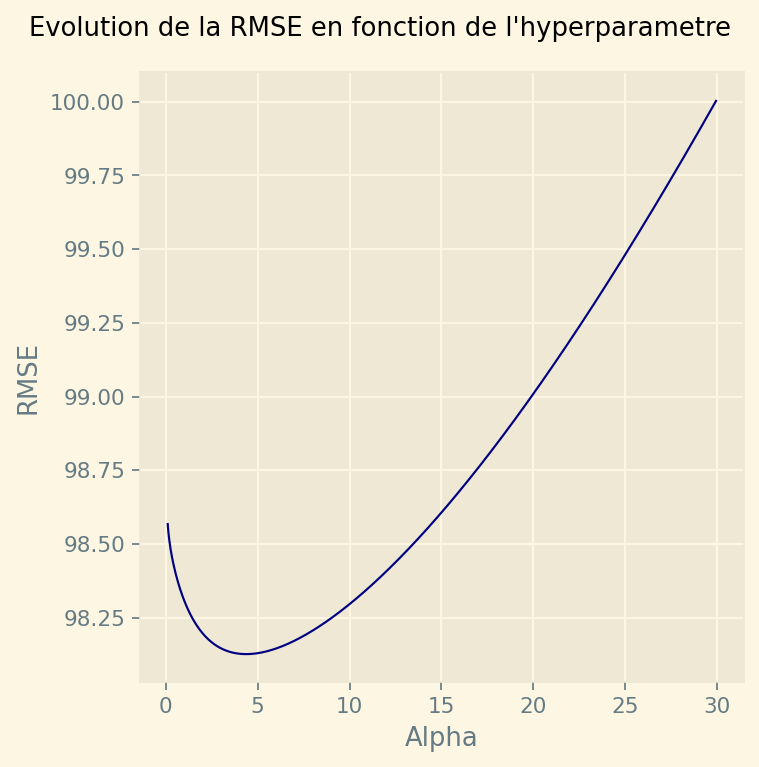

In [14]:
print("Ridge: \n")
print(f"Ridge best Alpha : {eui_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {eui_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.ridge_time_card.t_predict}")

eui_regression.ridge_plot()


LASSO: 

LASSO best Alpha : 0.85
Time used during fit = 0.44493924999999024
Time used during predict = 0.00033941600000275685


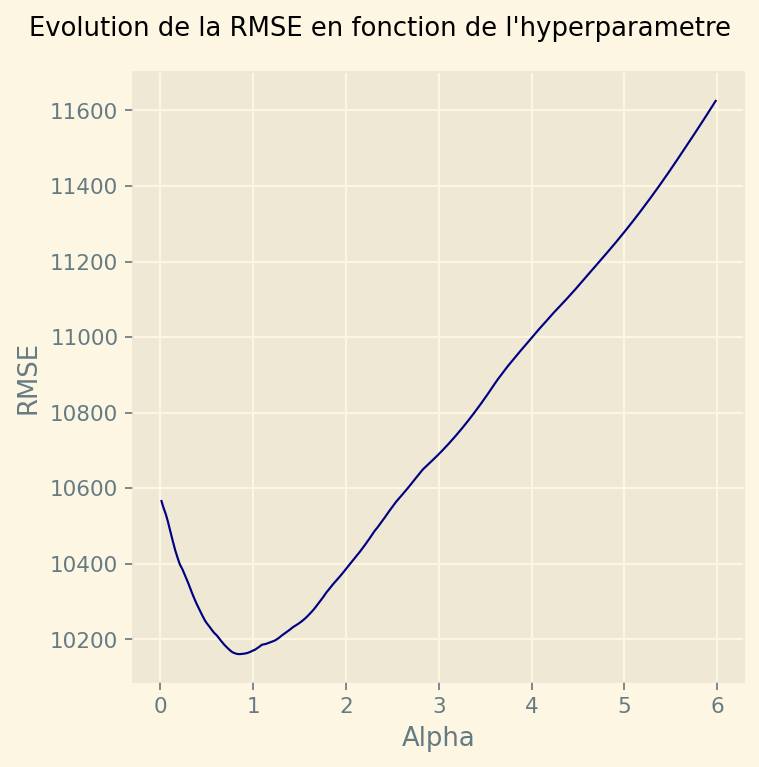

In [15]:
print("LASSO: \n")
print(f"LASSO best Alpha : {eui_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {eui_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.lasso_time_card.t_predict}")

eui_regression.lasso_plot()


In [16]:
metrics_l1out_estar = eui_regression.format_all_metrics()

metrics_l1out_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,102.927588,0.739177,98.126009,0.804202,100.801103,0.79761,148.763682,0.792113
Test,100.972351,0.748994,99.216284,0.757648,99.124506,0.758097,99.589362,0.755822
Test/Train,0.981,1.013,1.011,0.942,0.983,0.95,0.669,0.954


##### <u>Observations : 1.1.a :</u>
- Les modèles sont tous gloabelemnts performants.
- Le modele Ridge semble etre le plus performant sur les données d'entrainement avec une baisse du score R2 entre l'execution sur les donnees d'entrainement et sur les donnees de test.
- OLS est tres stable, on remarque des scores plus faibles que les autres regressions mais le modele est le seul a exceder les performaces attendues lors du passage au test (R2 plus haut, RMSE plus faible)
- ElasticNet semble etre le moins bon des modeles avec une RMSE de +|- 149 kWh/m2 sur le jeu de test

<hr>



#### 1.1.b : Cross validation = RepeatedKfold (10 folds aleatoires, 3 repetitions, i.e 30 folds)

- On utilise exactement les memes parametres que lors de la validation croisee utilisant Leave One Out
- On effectue 4 regressions (OLS, Ridge, Lasso et Elastic Net) avec les parametres par defaut de la classe pour la validation croisee
- Kfolds etant souvent beaucoup plus lourd a executer que Leave One Out, on attend de meilleurs scores mais des temps de traitement plus élevés

In [17]:
## Changing CV to RepeatedKfold :
k_folds = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

eui_regression.common_parameters["cv"] = k_folds


In [18]:
# Same split, same parameters, except cv = kfolds :

eui_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_lasso=alphas_lasso,
    alphas_ridge=alphas_ridge
)


In [19]:
metrics_kfold_estar = eui_regression.format_all_metrics()


In [20]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {eui_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {eui_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {eui_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.9600000000000001
Elastic Net best Alpha : 0.26
Time used during fit = 50.75679712499999
Time used during predict = 0.010336167000019714


In [21]:
print("Ridge: \n")
print(f"Ridge best Alpha : {eui_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {eui_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.ridge_time_card.t_predict}")


Ridge: 

Ridge best Alpha : 7.140000000000001
Time used during fit = 20.86989887499999
Time used during predict = 0.00021387499998581916


In [22]:
print("LASSO: \n")
print(f"LASSO best Alpha : {eui_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {eui_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.lasso_time_card.t_predict}")


LASSO: 

LASSO best Alpha : 0.8300000000000001
Time used during fit = 2.9146414999999877
Time used during predict = 0.0005994580000105998


In [23]:
print("# Metriques des regressions utilisant Kfold #")
metrics_kfold_estar


# Metriques des regressions utilisant Kfold #


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,99.348797,0.756539,0.872683,0.801196,98.551206,0.797924,150.864687,0.798745
Test,100.972351,0.748994,99.068543,0.75837,99.134332,0.758049,99.019096,0.758611
Test/Train,1.016,0.99,113.522,0.947,1.006,0.95,0.656,0.95


In [24]:
print("# Metriques des regressions utilisant Leave One Out #")
metrics_l1out_estar


# Metriques des regressions utilisant Leave One Out #


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,102.927588,0.739177,98.126009,0.804202,100.801103,0.79761,148.763682,0.792113
Test,100.972351,0.748994,99.216284,0.757648,99.124506,0.758097,99.589362,0.755822
Test/Train,0.981,1.013,1.011,0.942,0.983,0.95,0.669,0.954


##### Observations 1.1.b et comparaisons avec 1.1.a :

- Le temps d'execution est largement superieur, ce qui etait attendu
- La regression Ridge semble peut profiter de validation croisee par Kfold. Les performances sont extremement impressionantes sur le jeu d'entrainement (0.87 kWh/m2), mais il rentre dans les valeurs attendues (autour de 100kWh de RMSE) lors de son execution sur les donnees de test
- On peut questionner l'utilité de la validation par Kfold dans ce cas, meme si de tres faibles gains sont remarquables.
<br> 
<hr>
<br>
<b>Choix de Ridge Kfold :</b> <br>

- Le temps de fit est certes plus haut, mais une fois le modele entrainé, il predit les valeurs de test relativement precisement, et extremement rapidement.
- Elastic Net n'offre pas de gain significatif pour son temps d'entrainement largement superieur
- On analyse Ridge Kfold plus en details et c'est la regression principale qu'on utilisera pour comparer l'etape 1 à l'étape 2.

## <u>2 : Etude de l'importance de la note Energy Star</u>


### <u>2.0 : Utilisation de SHAP</u> pour determiner l'importance des differentes variables sur la regression retenue lors de l'etape precedente :

- On identifiera quels sont les principales features qui entrent en compte lors de la modelisation
- On pourra voir si la variable Energy Star Score figure parmi les plus importantes features

In [25]:
X_all = eui_regression.df_origin.drop(columns=[eui_target]).to_numpy()
X100 = shap.utils.sample(X_all, 100) # 100 instances for use as the background distribution

features = eui_regression.df_origin.drop(columns=[eui_target]).columns

explainer = shap.LinearExplainer(eui_regression.ridge_cv, X100, feature_names=features)
shap_values = explainer(X_all)


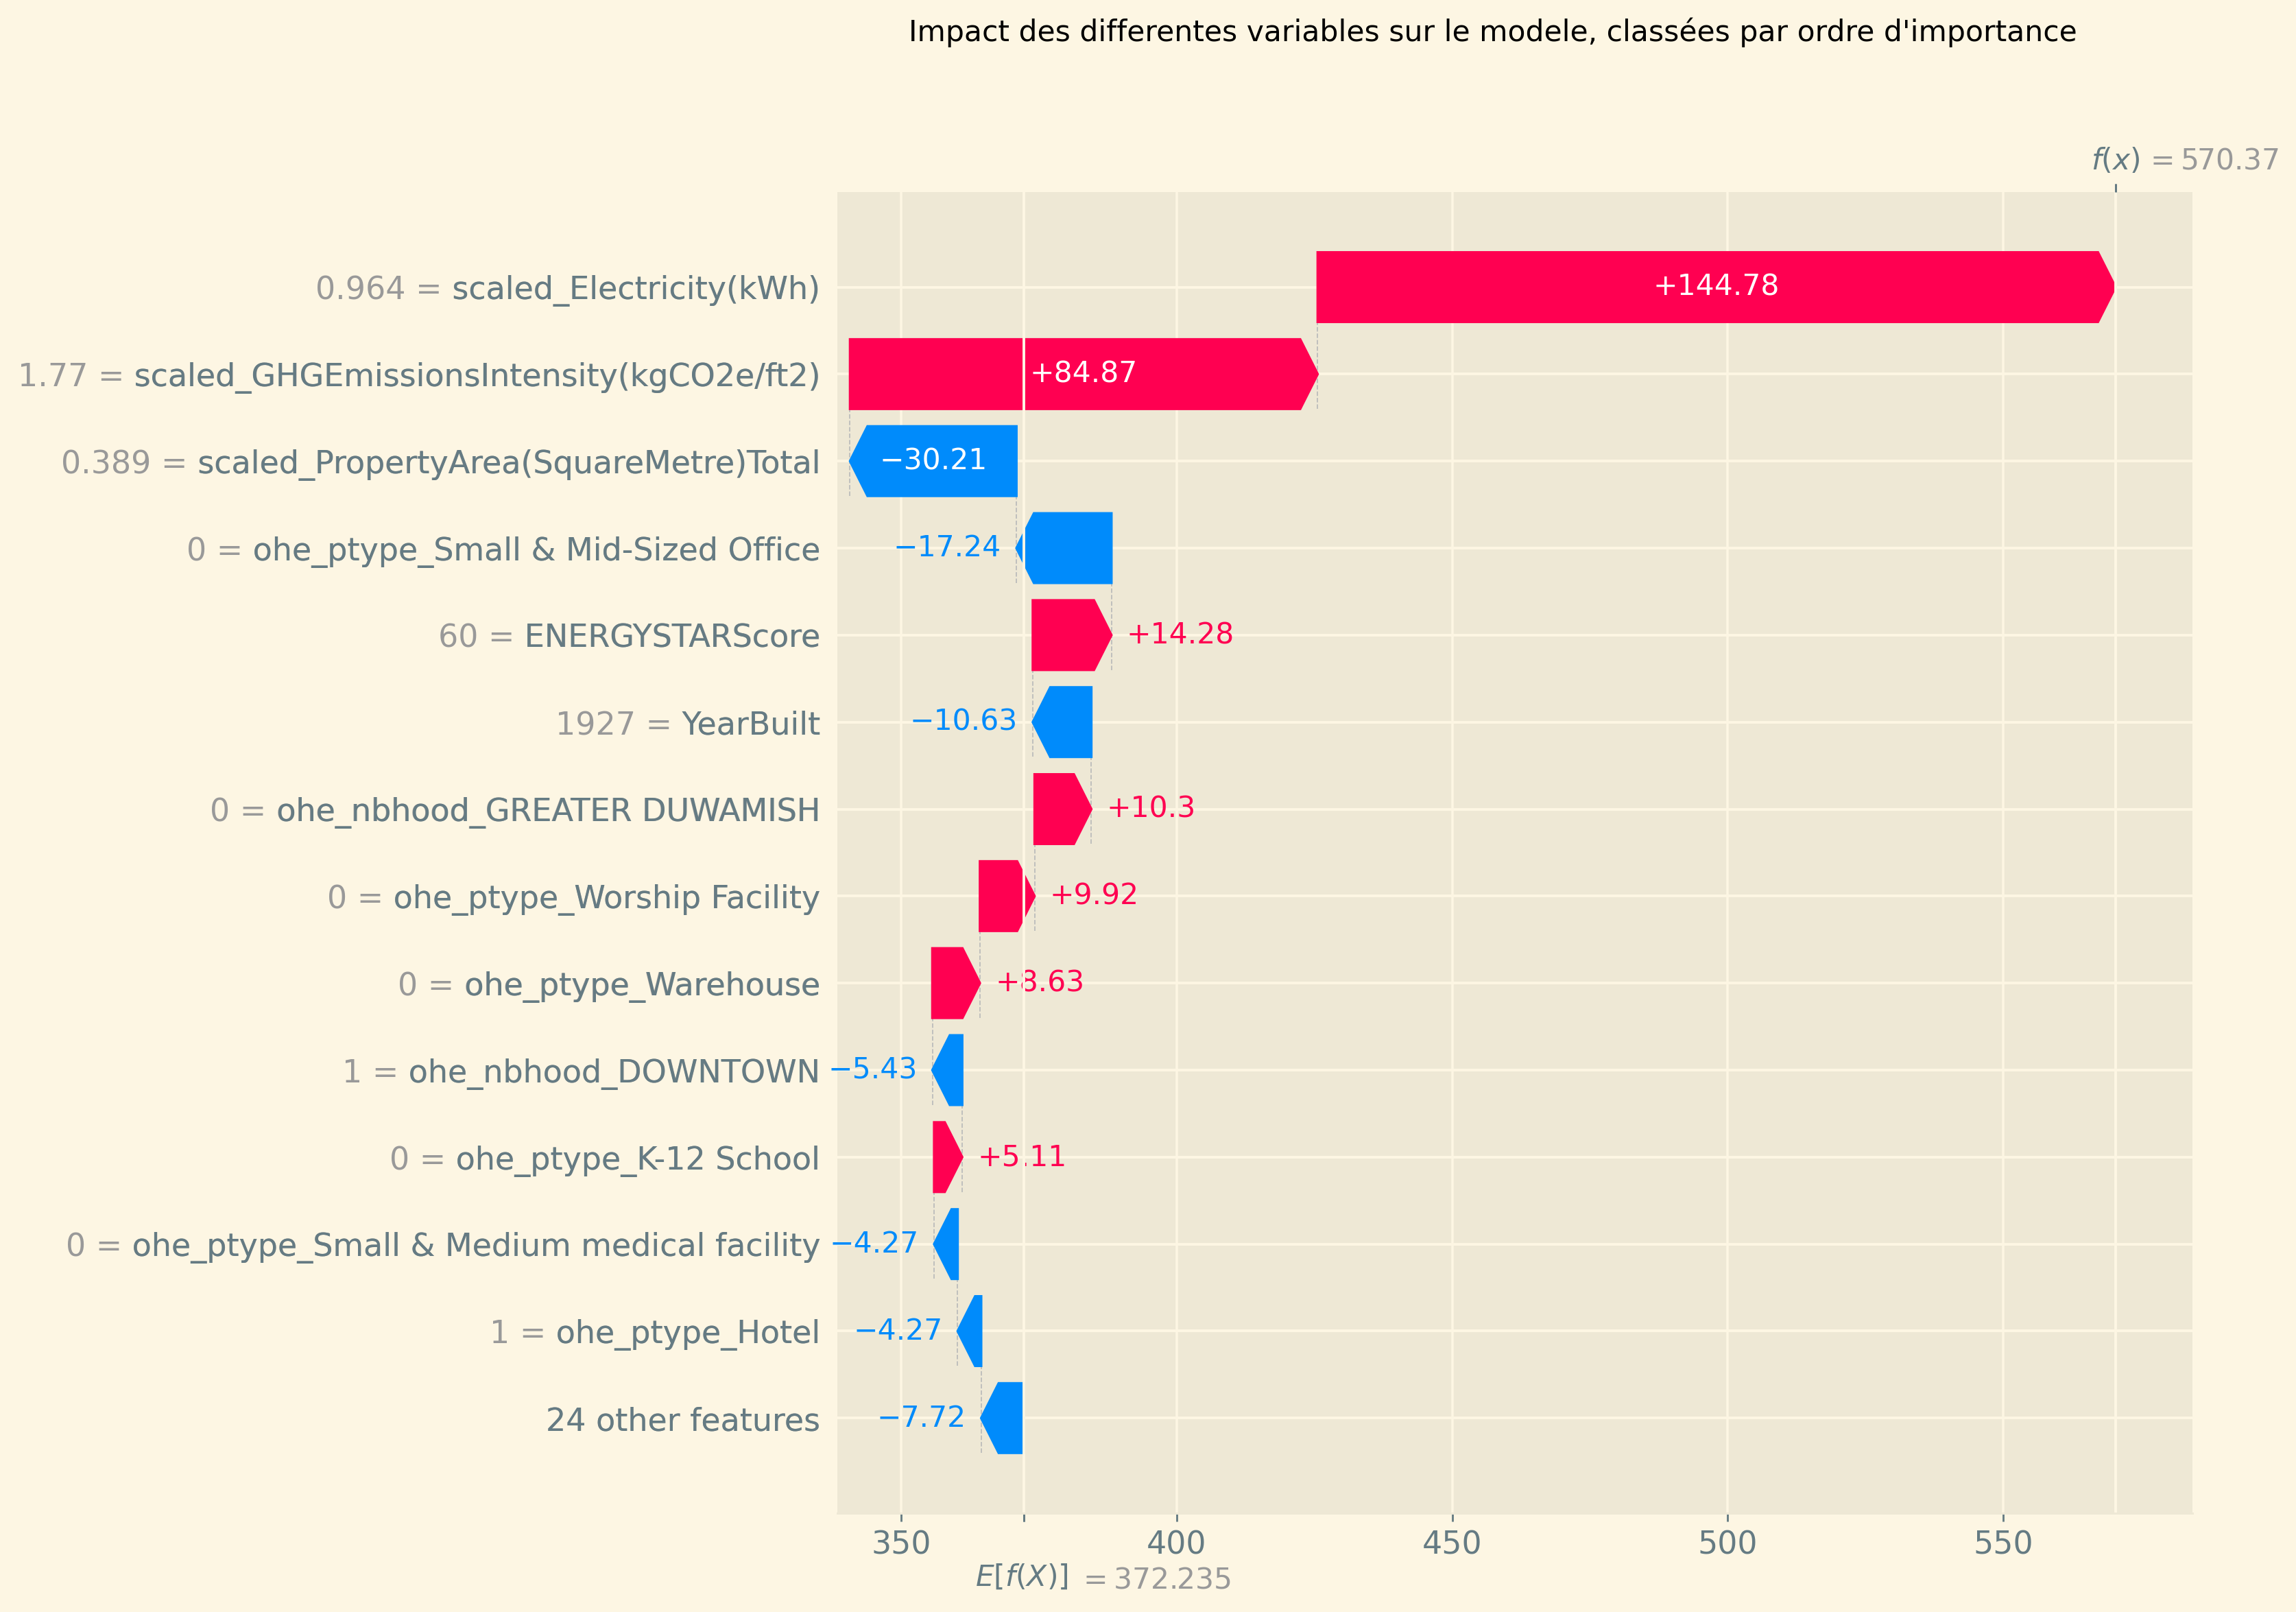

In [26]:
sample_ind = 18
my_waterfall = shap.plots.waterfall(shap_values[0], max_display=14, show=False)
my_waterfall.figure.set_size_inches(10, 10)
my_waterfall.figure.set_dpi(pc_dpi)

my_waterfall.suptitle("Impact des differentes variables sur le modele, classées par ordre d'importance")

plt.show()


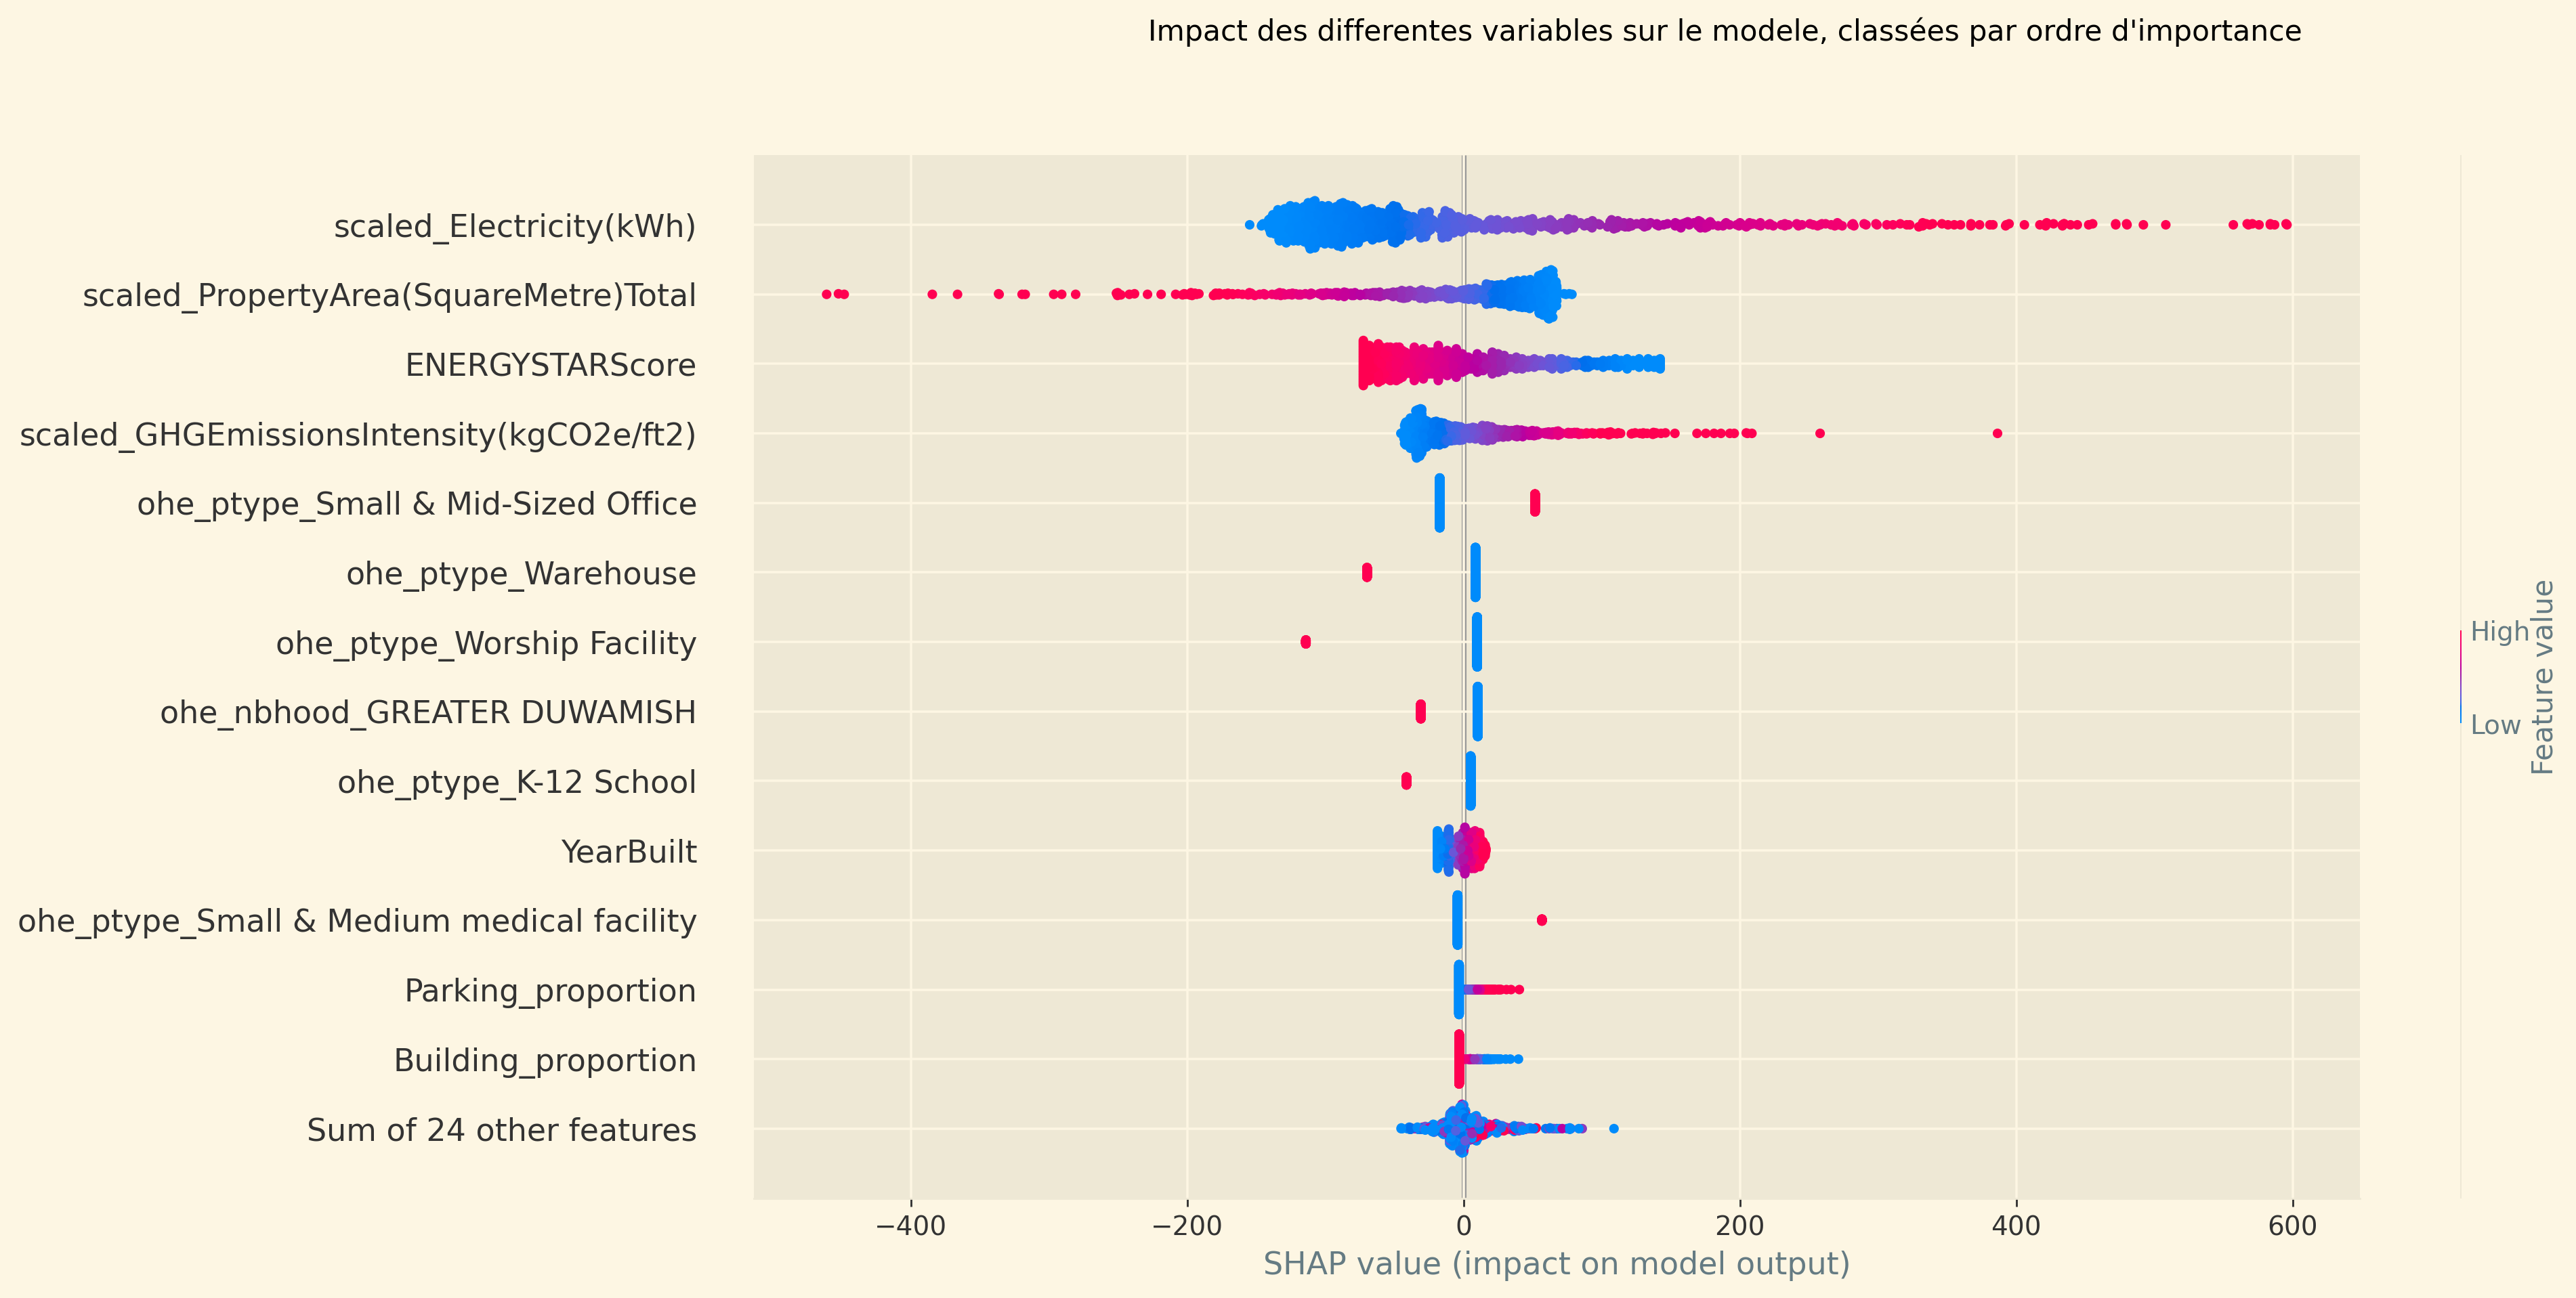

In [27]:
summary = shap.plots.beeswarm(shap_values, max_display=14, show=False)

summary.figure.set_size_inches(15, 8)
summary.figure.set_dpi(pc_dpi)

summary.suptitle("Impact des differentes variables sur le modele, classées par ordre d'importance")

plt.show()


#### Observations 2.0 : 

- Energy Star Score semble etre une valeur très importante au modèle : le plot summary (n2) montre que plus sa valeur est basse, plus l'intensité d'utilisation energetique augmente. Des valeurs hautes du score ("bons" scores) sont corrélés avec une valeur de sortie faible.

### <u>2.1 : Modelisation sans utiliser de variables E* (E* Score ou E* certified)</u>
### <u>2.2 : Utilisation de la certification plutot que le score</u>


In [28]:
drop_col = ["ENERGYSTARScore"]

eui_regression.drop_col(col_list=drop_col)

eui_regression.common_parameters["cv"] = None


In [29]:
eui_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_ridge=alphas_ridge,
    alphas_lasso=alphas_lasso
)


In [30]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {eui_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {eui_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {eui_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.8600000000000001
Elastic Net best Alpha : 0.22000000000000003
Time used during fit = 6.888339833000003
Time used during predict = 0.009443333000007215


Ridge: 

Ridge best Alpha : 2.5400000000000005
Time used during fit = 0.07613154200001304
Time used during predict = 6.933299999900555e-05


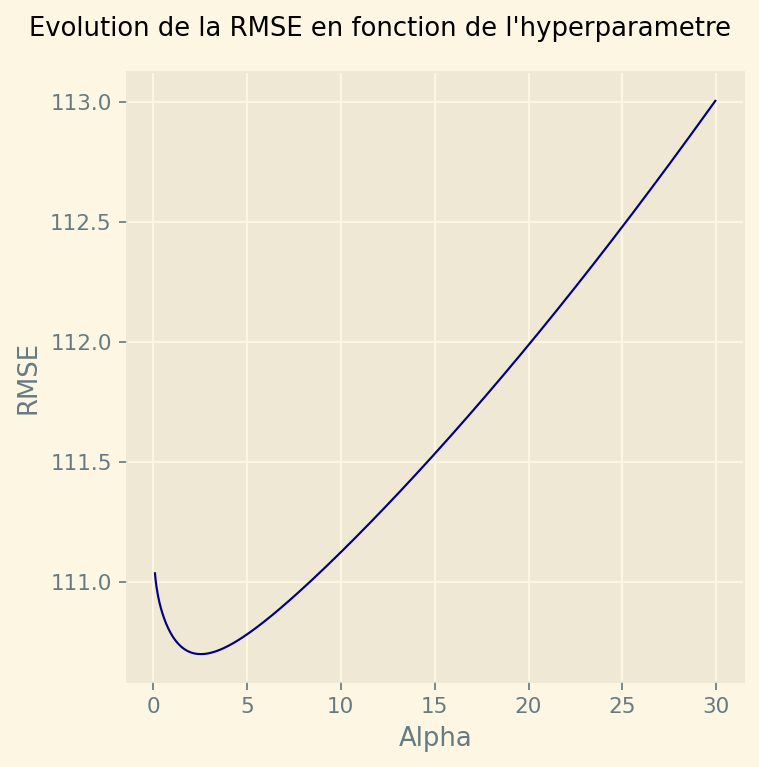

In [31]:
print("Ridge: \n")
print(f"Ridge best Alpha : {eui_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {eui_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.ridge_time_card.t_predict}")

eui_regression.ridge_plot()


LASSO: 

LASSO best Alpha : 0.9400000000000001
Time used during fit = 0.45148641699998393
Time used during predict = 0.00017662499999460124


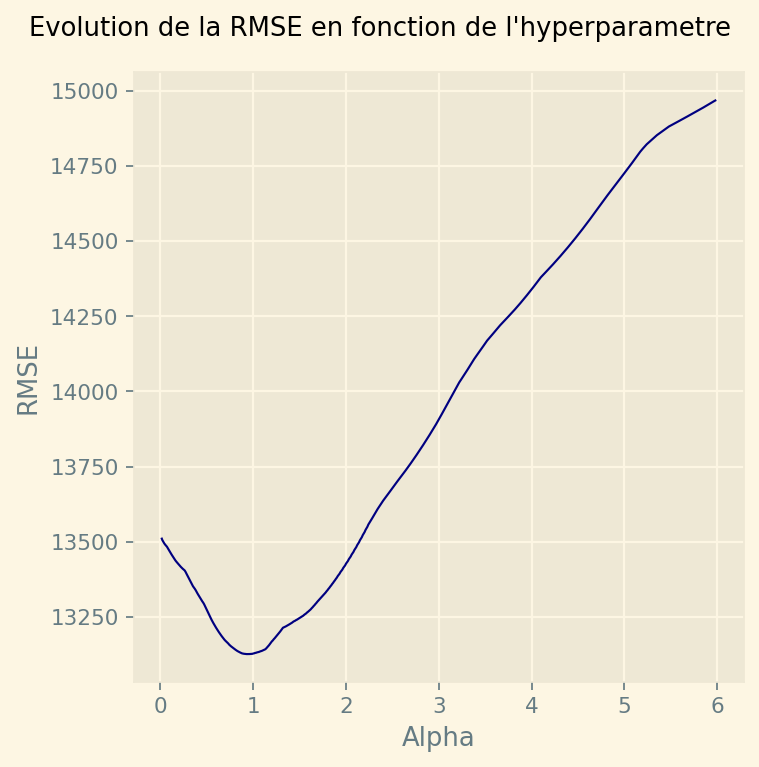

In [32]:
print("LASSO: \n")
print(f"LASSO best Alpha : {eui_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {eui_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.lasso_time_card.t_predict}")

eui_regression.lasso_plot()


In [33]:
metrics_l1out_no_estar = eui_regression.format_all_metrics()

metrics_l1out_no_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,116.370799,0.664779,110.698178,0.755193,114.566615,0.745329,161.569586,0.731417
Test,116.627641,0.665125,115.450978,0.671848,114.490736,0.677284,117.251851,0.661531
Test/Train,1.002,1.001,1.043,0.89,0.999,0.909,0.726,0.904


In [34]:
metrics_l1out_estar

,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,102.927588,0.739177,98.126009,0.804202,100.801103,0.79761,148.763682,0.792113
Test,100.972351,0.748994,99.216284,0.757648,99.124506,0.758097,99.589362,0.755822
Test/Train,0.981,1.013,1.011,0.942,0.983,0.95,0.669,0.954


#### heavy losses on all models
#### using kfold

In [35]:
eui_regression.common_parameters["cv"] = k_folds


In [36]:
eui_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_ridge=alphas_ridge,
    alphas_lasso=alphas_lasso
)


In [37]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {eui_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {eui_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {eui_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.9600000000000001
Elastic Net best Alpha : 0.1
Time used during fit = 42.573750665999995
Time used during predict = 0.00869650000001343


In [38]:
print("Ridge: \n")
print(f"Ridge best Alpha : {eui_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {eui_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.ridge_time_card.t_predict}")

eui_regression.ridge_plot()


Ridge: 

Ridge best Alpha : 4.78
Time used during fit = 22.10341466600002
Time used during predict = 5.7749999996303814e-05
Cannot use plot on ridge regression with CV not None, cf. sklearn doc on "store_cv_values" on RidgeCV


In [39]:
print("LASSO: \n")
print(f"LASSO best Alpha : {eui_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {eui_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {eui_regression.lasso_time_card.t_predict}")


LASSO: 

LASSO best Alpha : 0.88
Time used during fit = 3.242150167000034
Time used during predict = 0.0008360420000030899


In [40]:
metrics_kfold_no_estar = eui_regression.format_all_metrics()

metrics_kfold_no_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,111.425689,0.695124,0.836019,0.752317,110.899679,0.746431,162.376354,0.754303
Test,116.627641,0.665125,115.349439,0.672425,114.499946,0.677232,115.139176,0.673618
Test/Train,1.047,0.957,137.975,0.894,1.032,0.907,0.709,0.893


In [41]:
metrics_kfold_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,99.348797,0.756539,0.872683,0.801196,98.551206,0.797924,150.864687,0.798745
Test,100.972351,0.748994,99.068543,0.75837,99.134332,0.758049,99.019096,0.758611
Test/Train,1.016,0.99,113.522,0.947,1.006,0.95,0.656,0.95


#### heavy performances losses aswl

- Ici, contrairement a la modelisation de la prediction d'emission de GaES, la variable E* score semble très importante. On note de fortes baisses du score R2 de chaque modèle, et egalement une augmentation de l'erreur RMSE

#### Hypothèses :

- On sait que les batiments notés par EnergyStar sont qualifiés EnergyStar Certified s'ils ont une note superieure ou egale a 75.
- Est il possible de predire avec une haute confiance si un batiment aura une certification ou non ?
- Si oui, cette nouvelle statistique booleene aurait-elle un impact sur notre modele ? Si c'est le cas, il serait avantageux de tenter de predire ce score en utilisant des methode de classification. Cela permettrait d'avoir moins recours au calcul du score Per Se tout en retenant les benefices clairs apportés par cette variable

### 2.2 Transformation de la donnée E* Score vers E* Certified

In [42]:
df_eui["energy_star_certified"] = 0
# df_eui["energy_star_certified"] = df_eui["energy_star_certified"].astype(int)

df_eui.loc[df_eui["ENERGYSTARScore"] >= 75, "energy_star_certified"] = 1

df_eui[df_eui["energy_star_certified"] == 0].head(n=4)


,scaled_Electricity(kWh),scaled_GHGEmissionsIntensity(kgCO2e/ft2),scaled_PropertyArea(SquareMetre)Total,scaled_SourceEUI(kWh/m2),scaled_NaturalGas(kWh),YearBuilt,NumberofBuildings,NumberofFloors,ENERGYSTARScore,Building_proportion,...,ohe_ptype_Office,ohe_ptype_Other,ohe_ptype_Refrigerated Warehouse,ohe_ptype_Residence Hall,ohe_ptype_Small & Medium medical facility,ohe_ptype_Small & Mid-Sized Office,ohe_ptype_Supermarket & Grocery store,ohe_ptype_Warehouse,ohe_ptype_Worship Facility,energy_star_certified
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,
1,0.963847,1.770173,0.389139,1.012887,0.500705,1927,1,12,60.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.615322,1.799564,0.659821,0.913481,4.178122,1996,1,11,61.0,0.855,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.380423,3.572830,-0.095878,1.536320,1.009034,1926,1,10,56.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
10,0.401384,1.074583,0.292078,0.455283,2.089235,1926,1,11,27.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [43]:
df_eui[df_eui["energy_star_certified"] == 1].head(n=4)


,scaled_Electricity(kWh),scaled_GHGEmissionsIntensity(kgCO2e/ft2),scaled_PropertyArea(SquareMetre)Total,scaled_SourceEUI(kWh/m2),scaled_NaturalGas(kWh),YearBuilt,NumberofBuildings,NumberofFloors,ENERGYSTARScore,Building_proportion,...,ohe_ptype_Office,ohe_ptype_Other,ohe_ptype_Refrigerated Warehouse,ohe_ptype_Residence Hall,ohe_ptype_Small & Medium medical facility,ohe_ptype_Small & Mid-Sized Office,ohe_ptype_Supermarket & Grocery store,ohe_ptype_Warehouse,ohe_ptype_Worship Facility,energy_star_certified
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,
28,-0.527582,-0.326395,-0.186964,-0.878927,-0.139915,1961,1,2,95.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
29,0.131266,-0.003093,0.391965,0.477028,0.615582,2001,1,6,84.0,0.655,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
36,-0.026661,0.643513,1.680854,-0.763990,3.880108,1949,1,2,75.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
50,-0.388487,-0.443960,-0.209181,-0.613328,-0.301354,1990,1,2,97.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [44]:
df_model_two = df_eui.drop(columns=["ENERGYSTARScore"])


In [45]:
df_model_two.drop(columns=droplist, inplace=True)

cert_regression = Linear_reg(dataframe=df_model_two, target=eui_target)


In [46]:
# Reset common parameters to None for cv

cert_regression.common_parameters["cv"] = None

cert_regression.get_common_params()


scoring = neg_mean_squared_error
cv = None
n_jobs = -1


In [47]:
# Using same split : 

# Forcing split : 

df_train_override_two = df_model_two[df_model_two.index.isin(ids_train)]
df_test_override_two = df_model_two[df_model_two.index.isin(ids_test)]

cert_regression.force_split(
    df_train_ovr=df_train_override_two,
    df_test_ovr=df_test_override_two
)


Same parameters, its the 3rd time, you know the drill

In [48]:
# Let's fire up this bad boy : 
# Do me proud homes

cert_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_ridge=alphas_ridge,
    alphas_lasso=alphas_lasso
)


In [49]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {cert_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {cert_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {cert_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {cert_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.9600000000000001
Elastic Net best Alpha : 0.5800000000000001
Time used during fit = 6.90812112499998
Time used during predict = 0.00024854100001903134


Ridge: 

Ridge best Alpha : 4.260000000000001
Time used during fit = 0.17132816700001285
Time used during predict = 9.162499998183193e-05


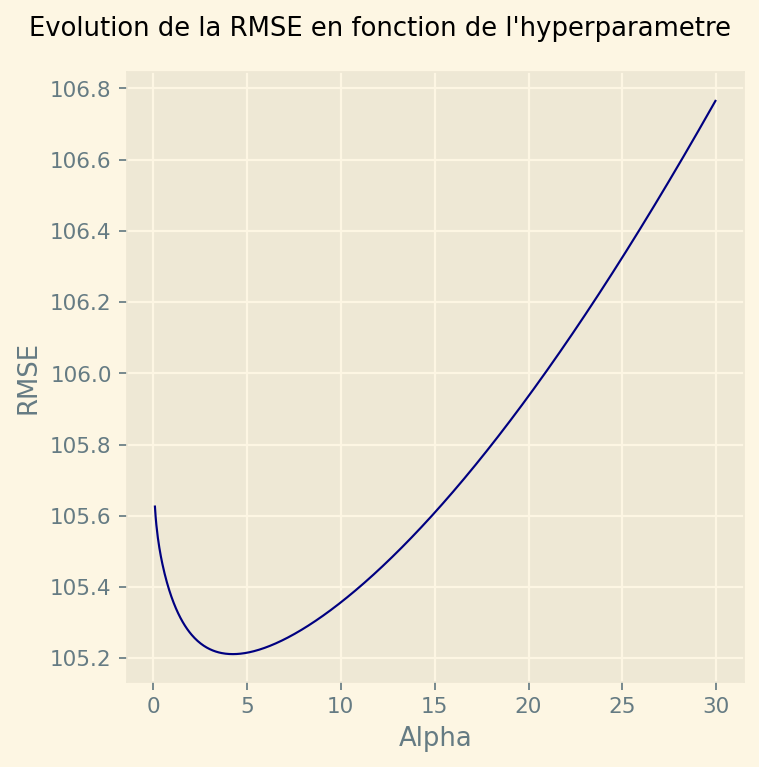

In [50]:
print("Ridge: \n")
print(f"Ridge best Alpha : {cert_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {cert_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {cert_regression.ridge_time_card.t_predict}")

cert_regression.ridge_plot()


LASSO: 

LASSO best Alpha : 0.93
Time used during fit = 0.40963758300000563
Time used during predict = 0.0009321249999629799


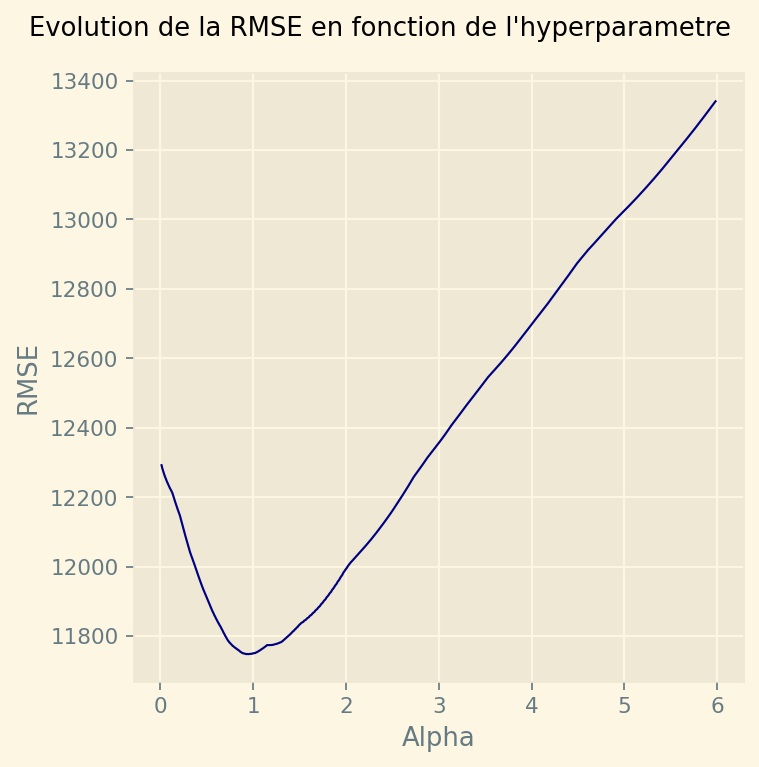

In [51]:
print("LASSO: \n")
print(f"LASSO best Alpha : {cert_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {cert_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {cert_regression.lasso_time_card.t_predict}")

cert_regression.lasso_plot()


In [52]:
cert_metrics_l1out = cert_regression.format_all_metrics()

cert_metrics_l1out


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,111.003891,0.694719,105.211403,0.779222,108.389185,0.771151,158.384271,0.759554
Test,107.295367,0.716573,105.955477,0.723607,105.359788,0.726706,107.453547,0.715736
Test/Train,0.967,1.031,1.007,0.929,0.972,0.942,0.678,0.942


In [53]:
metrics_l1out_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,102.927588,0.739177,98.126009,0.804202,100.801103,0.79761,148.763682,0.792113
Test,100.972351,0.748994,99.216284,0.757648,99.124506,0.758097,99.589362,0.755822
Test/Train,0.981,1.013,1.011,0.942,0.983,0.95,0.669,0.954


In [54]:
metrics_l1out_no_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,116.370799,0.664779,110.698178,0.755193,114.566615,0.745329,161.569586,0.731417
Test,116.627641,0.665125,115.450978,0.671848,114.490736,0.677284,117.251851,0.661531
Test/Train,1.002,1.001,1.043,0.89,0.999,0.909,0.726,0.904


In [55]:
cert_regression.common_parameters["cv"] = k_folds


cert_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_ridge=alphas_ridge,
    alphas_lasso=alphas_lasso
)


In [56]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {cert_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {cert_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {cert_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {cert_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.91
Elastic Net best Alpha : 0.14
Time used during fit = 43.45490254200001
Time used during predict = 0.01015704199994616


In [57]:
print("Ridge: \n")
print(f"Ridge best Alpha : {cert_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {cert_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {cert_regression.ridge_time_card.t_predict}")


Ridge: 

Ridge best Alpha : 7.140000000000001
Time used during fit = 22.645068541
Time used during predict = 5.4499999976087565e-05


In [58]:
print("LASSO: \n")
print(f"LASSO best Alpha : {cert_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {cert_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {cert_regression.lasso_time_card.t_predict}")


LASSO: 

LASSO best Alpha : 0.92
Time used during fit = 2.8770572909999714
Time used during predict = 0.00021366699996860916


In [59]:
cert_metrics_kfolds = cert_regression.format_all_metrics()

cert_metrics_kfolds


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,105.770052,0.724164,0.853657,0.77588,104.867127,0.77132,159.450892,0.773524
Test,107.295367,0.716573,105.963408,0.723566,105.35888,0.726711,105.953628,0.723617
Test/Train,1.014,0.99,124.129,0.933,1.005,0.942,0.664,0.935


In [60]:
cert_metrics_l1out


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,111.003891,0.694719,105.211403,0.779222,108.389185,0.771151,158.384271,0.759554
Test,107.295367,0.716573,105.955477,0.723607,105.359788,0.726706,107.453547,0.715736
Test/Train,0.967,1.031,1.007,0.929,0.972,0.942,0.678,0.942


In [61]:
metrics_kfold_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,99.348797,0.756539,0.872683,0.801196,98.551206,0.797924,150.864687,0.798745
Test,100.972351,0.748994,99.068543,0.75837,99.134332,0.758049,99.019096,0.758611
Test/Train,1.016,0.99,113.522,0.947,1.006,0.95,0.656,0.95


In [62]:
metrics_kfold_no_estar


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,111.425689,0.695124,0.836019,0.752317,110.899679,0.746431,162.376354,0.754303
Test,116.627641,0.665125,115.349439,0.672425,114.499946,0.677232,115.139176,0.673618
Test/Train,1.047,0.957,137.975,0.894,1.032,0.907,0.709,0.893


#### Observations :
- Les resultats sont encourageants. Il est evident que la certification, ou non, d'un batiment n'est pas aussi precise que son score mais on obtient un gain significatif par rapport aux modeles n'utilisant pas du tout le score EnergyStar.
- Si l'on garde l'exemple de Ridge, on obtient des resultats sensiblement plus optimistes. On perd certes en precision et on augmente l'erreur vis à vis du modele utilisant E* seul, mais cela peut etre un compromis interessant.
- On peut etudier l'importance de la feature avec la meme methode (shap) utilisee lors des precedents exemples. On s'attend a la voir contribuer substantiellement au modele.

In [63]:
X_all_cert = cert_regression.df_origin.drop(columns=[eui_target]).to_numpy()
X100 = shap.utils.sample(X_all_cert, 100) # 100 instances for use as the background distribution

features_cert = cert_regression.df_origin.drop(columns=[eui_target]).columns

explainer = shap.LinearExplainer(cert_regression.ridge_cv, X100, feature_names=features_cert)
shap_values = explainer(X_all_cert)


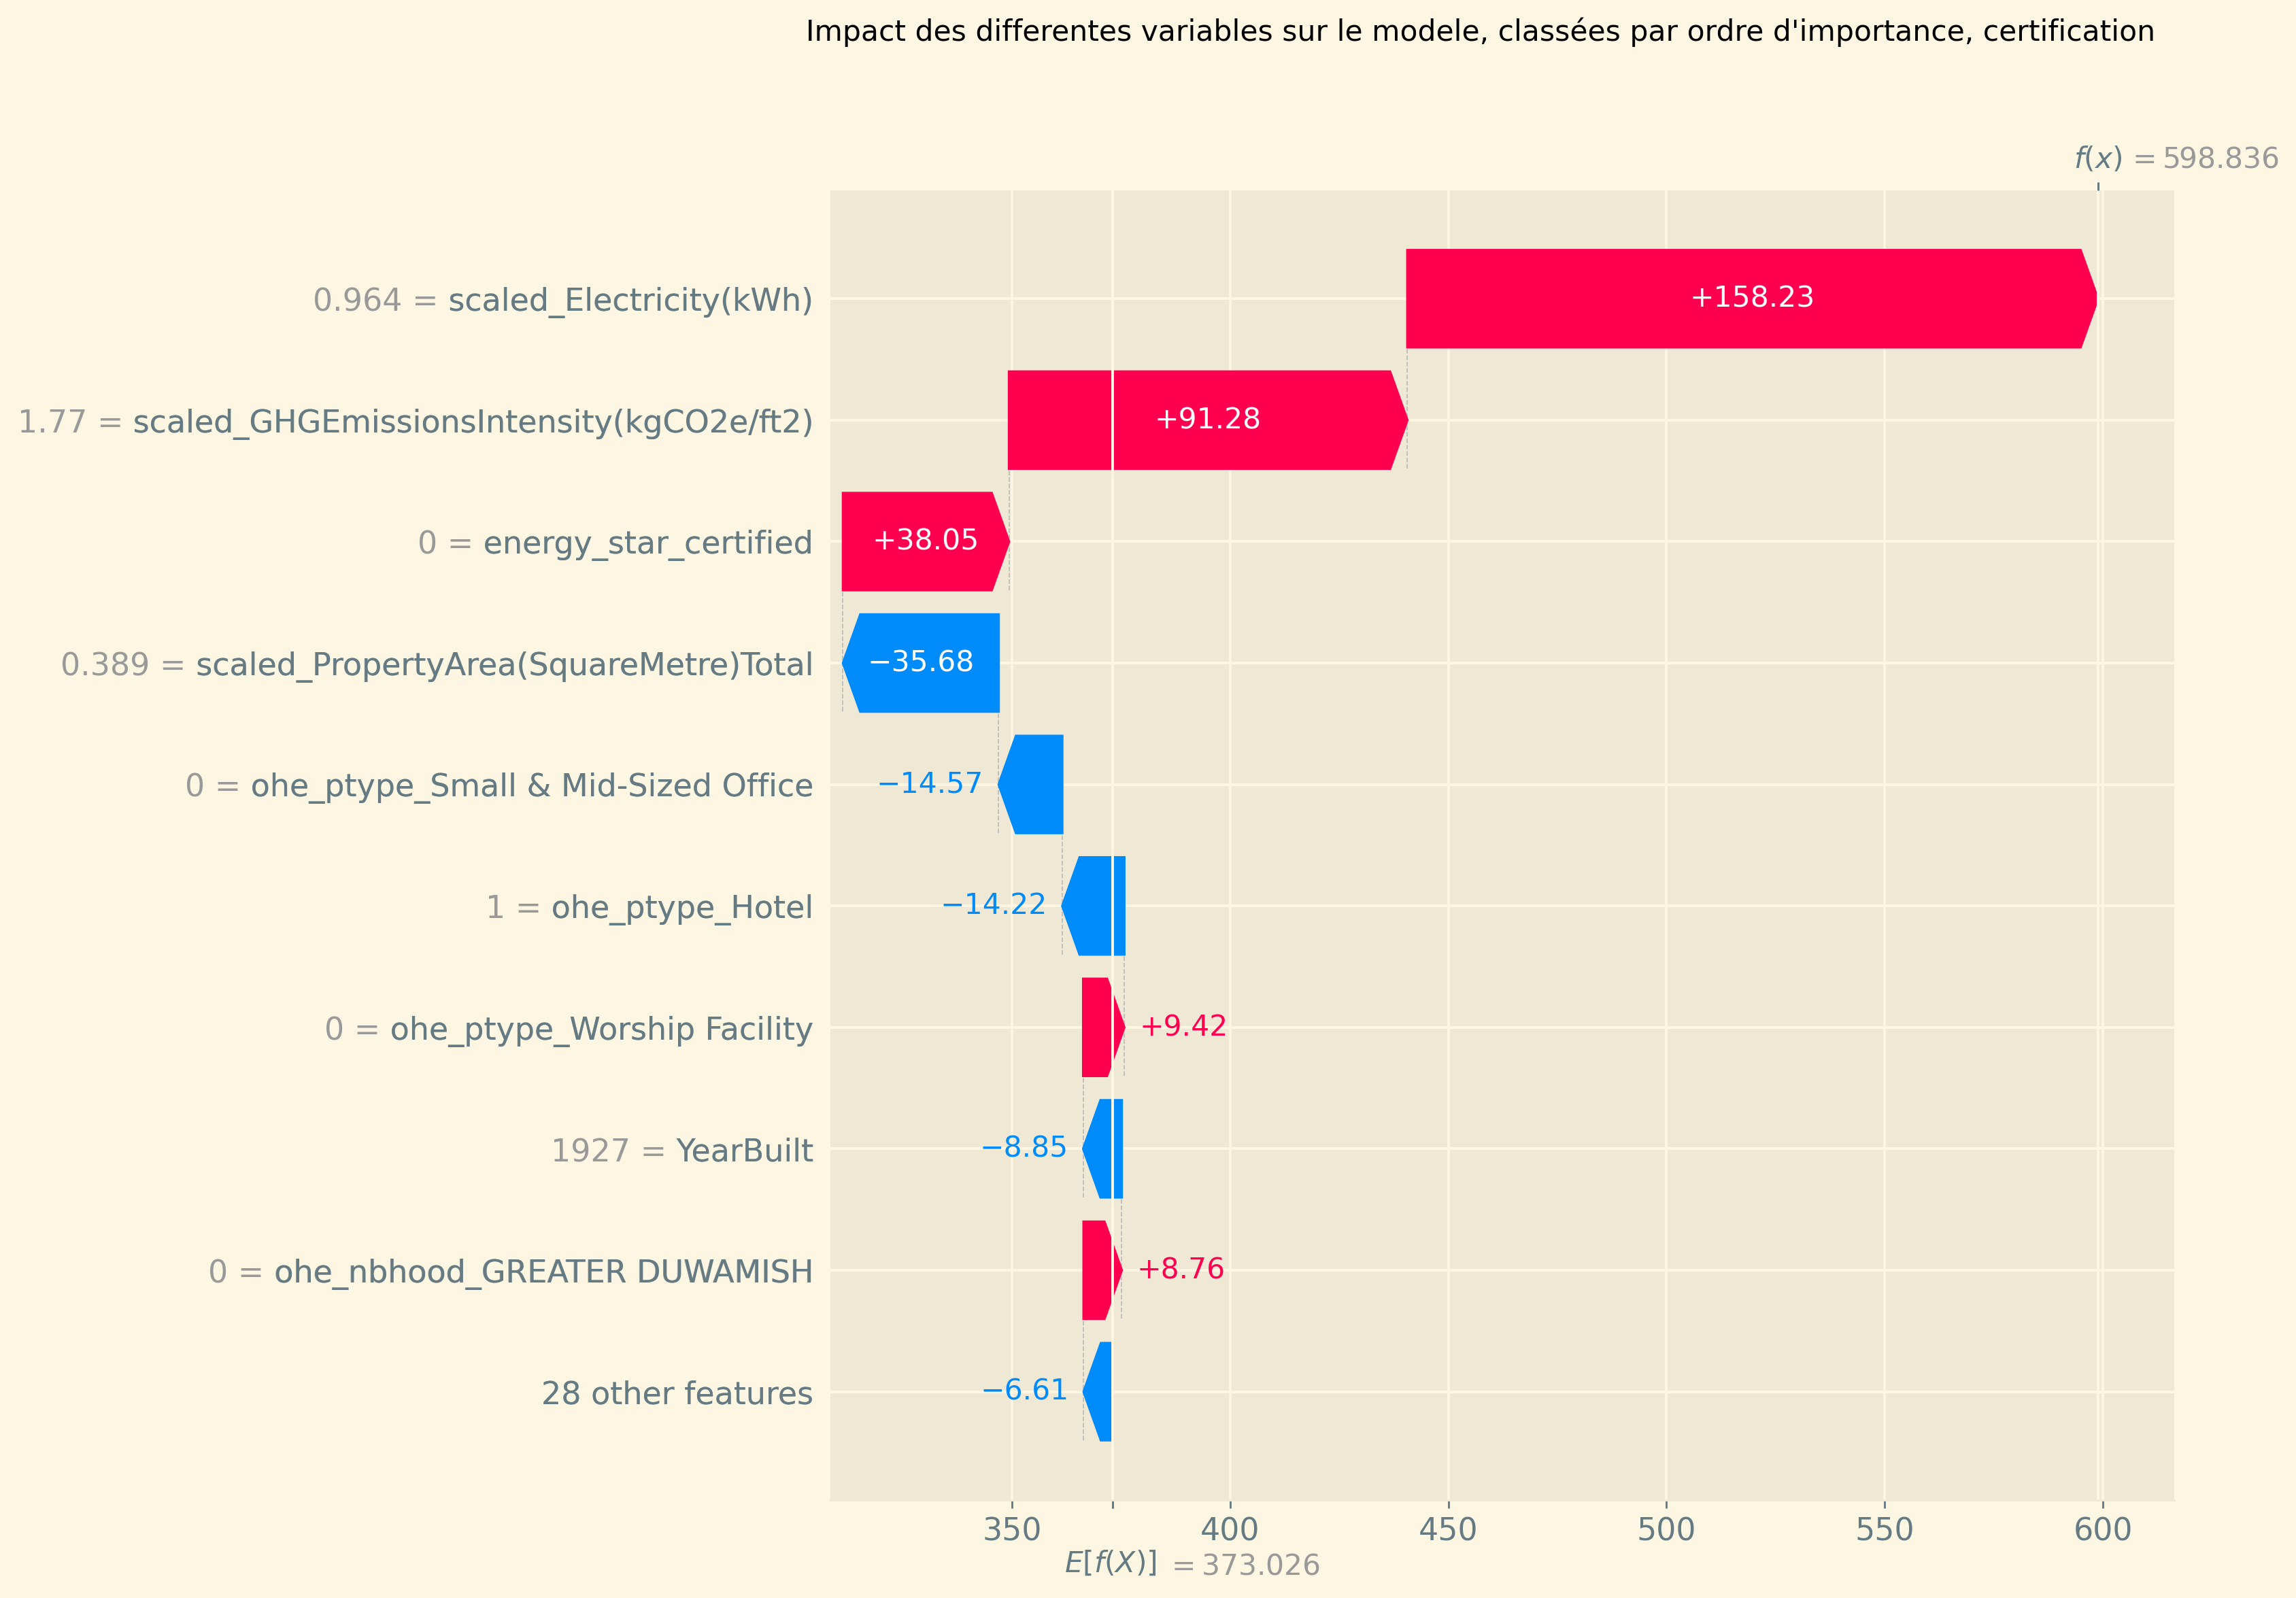

In [64]:
sample_ind = 18
my_waterfall = shap.plots.waterfall(shap_values[0], max_display=10, show=False)
my_waterfall.figure.set_size_inches(10, 10)
my_waterfall.figure.set_dpi(pc_dpi)

my_waterfall.suptitle("Impact des differentes variables sur le modele, classées par ordre d'importance, certification")

plt.show()


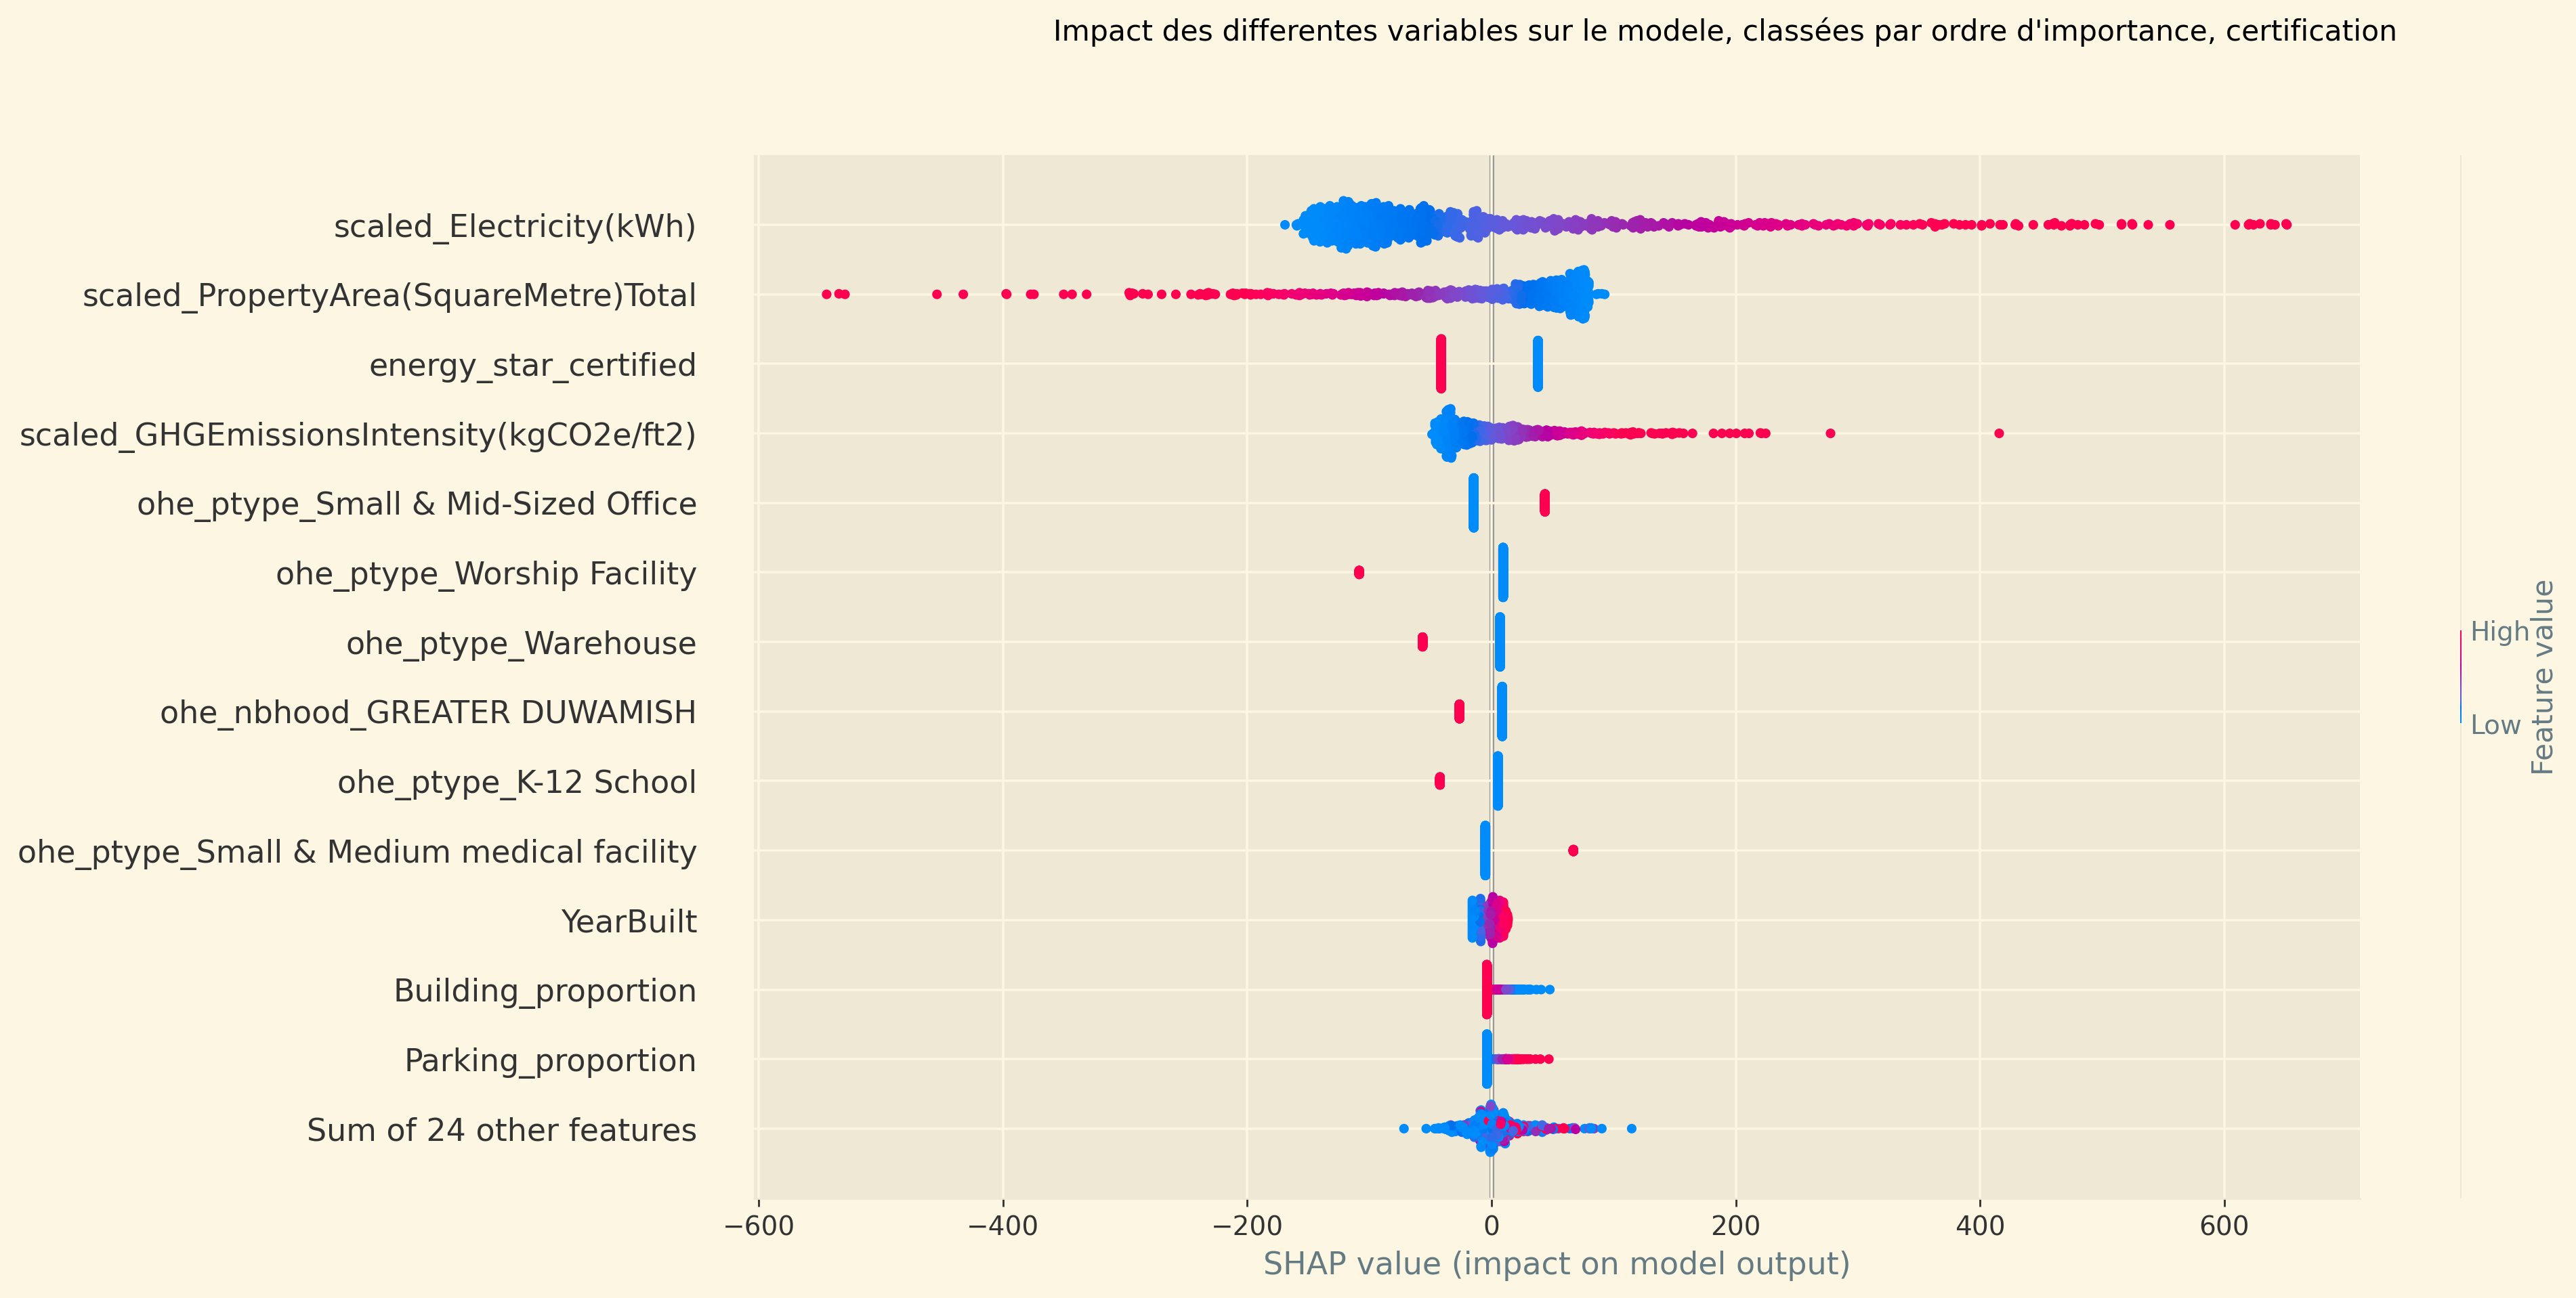

In [65]:
summary = shap.plots.beeswarm(shap_values, max_display=14, show=False)

summary.figure.set_size_inches(15, 8)
summary.figure.set_dpi(pc_dpi)

summary.suptitle("Impact des differentes variables sur le modele, classées par ordre d'importance, certification")

plt.show()


### Observations sur l'hypothese et ouverture vers un autre probleme. Conclusion générale.

- L'hypothèse selon laquelelle la certification, ou non, d'un batiment apporte une contribution sembable en terme d'impact à celle de la Note Per Se.
- Les resultats sont particulierement interessants dans la mesure ou l'on passe d'une note sur 100 à une valeur binaire.
- Cependant, un autre probleme se pose : Nous avons pu etablir la certification des batiments en connaissant a priori leurs notes. L'idée est d'essayer de moins s'appuyer sur cette note - En clair, une nouvelle problematique emerge : Est il possible de predire si un batiment sera certifié ou non, en se basant sur les variables connues.
    - Dans le cas ou cela est possible est suffisamment precis, cette alternative est un bon compromis entre les pertes de performances consequentes dues à l'elimination totale d'E*.
    - Dans le cas ou cela est impossible ou trop peu precis. On recommandera, au possible, d'effectuer les calculs de ce score. La difference "avec/sans" est trop importante et le score beneficie bien trop au modele pour s'en passer.
- Dans l'ensemble, l'utilisation de Ridge, ici en utilisant Kfold (repetition 3 fois de 10 folds) est recommandée : c'est le modèle le plus precis même si quelque peu inconstant.